# Timeseries



In [ ]:
# setup notebook
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}
%load_ext autoreload
%autoreload 2

In [14]:
import xarray as xr
import figanos.matplotlib as fg
import numpy as np
from matplotlib import pyplot as plt
from xclim import set_options

# load Ouranos style and colors
fg.utils.set_mpl_style("ouranos")
from matplotlib.patches import Rectangle

# load dataset
url = "https://pavics.ouranos.ca//twitcher/ows/proxy/thredds/dodsC/birdhouse/disk2/cccs_portal/indices/Final/BCCAQv2_CMIP6/tx_max/YS/ssp585/ensemble_percentiles/tx_max_ann_BCCAQ2v2+ANUSPLIN300_historical+ssp585_1950-2100_30ymean_percentiles.nc"
opened = xr.open_dataset(url, decode_timedelta=False)
ds_time = opened.isel(lon=500, lat=250)[["tx_max_p50", "tx_max_p10", "tx_max_p90"]]

## Using the Ouranos stylesheet

Most parameters affecting the style of plots can be set through matplotlib stylesheets. Figanos includes custom stylesheets that can be accessed through the `set_mpl_style()` function. Paths to your own stylesheets (`'.mplstyle'` extension) can also be passed to this function. To use the built-in matplotlib styles, use `mpl.style.use()`.

The currently available stylesheets are as follows:

* `"ouranos"`: General stylesheet, including default colors.
* `"transparent"`: Adds transparency to the styles (fully transparent figure background and 30% opacity on the axes).

One of the features of the stylesheet is to redefine the default colors to match Ouranos palette.

In [ ]:
# display the cycler colors
from matplotlib.patches import Rectangle
import matplotlib

style_colors = matplotlib.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(figsize=(10, 3))
for color, x in zip(style_colors, np.arange(0, len(style_colors) * 2, 2)):
    ax.add_patch(Rectangle(xy=(x, 1), width=0.8, height=0.5, facecolor=color))
    ax.text(x, 0.5, str(color), color=color)

ax.set_ylim(0, 2)
ax.set_xlim(0, 14)
ax.set_aspect("equal")
ax.set_axis_off()

## Basic timeseries
The [**timeseries()**](#timeseries) function accepts DataArrays or Datasets.

In [ ]:
fg.timeseries(ds_time.tx_max_p50);

In [ ]:
# plt.savefig("images/basic_timeseries.png", bbox_inches='tight')

## Using the dictionary interface

To plot many lines, users need to input dictionaries instead of a simple dataset.

The main elements of a plot are dependent on four arguments, each accepting dictionaries:

1. `data` : a dictionary containing the Xarray objects and their respective keys, used as labels on the plot.
2. `use_attrs`: a dictionary linking attributes from the Xarray object to plot text elements.
3. `fig_kw`: a dictionary to pass arguments to the `plt.figure()` instance.
4. `plot_kw` : a dictionary using the same keys as `data` to pass arguments to the underlying plotting function, in this case [matplotlib.axes.Axes.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html).

When labels are passed in `data`, any 'label' argument passed in `plot_kw` will be ignored.

In [ ]:
my_data = {
    "50th percentile": ds_time.tx_max_p50,
    "90th percentile": ds_time.tx_max_p90,
}
plot_kws = {"90th percentile": {"linestyle": "--"}}

fg.timeseries(my_data, plot_kw=plot_kws, show_lat_lon=False)

## Customizing plots

Plots created with Figanos can be customized in two different ways:

1. By using the built-in options through arguments (e.g. changing the type of the legend with the `legend` argument).
2. By creating a Matplotlib `Axes` class instance and using its methods (e.g. setting a new title with `ax.set_title()`).

Both of these types of customization are demonstrated below. In some cases, both methods can achieve the same result.

In [ ]:
ax = fg.timeseries(
    my_data,
    show_lat_lon="upper left",  # fun legend option, moved latitude and longitude tag
    legend="edge",
    use_attrs={"ylabel": "standard_name"},  # will look for an attribute 'standard name' in the first entry of my_data
)
ax.set_title("Custom Title", loc="left")  # when the title is left aligned, the "loc=left" argument must be used.
# to remove a title, use ax.set_title('', loc='left')
ax.set_xlabel("Custom xlabel")
ax.set_ylabel("Custom ylabel")
ax.grid(False)  # removing the gridlines
ax.set_yticks([300, 310])  # Custom yticks

## Ensembles

When Datasets are passed to the timeseries function, certain names and data configurations will be recognized and will result in certain kinds of plots.

| Dataset configuration | Resulting plot | Notes |
|:----------:|:--------------:|:----------------:|
|Variables contain a substring of the format "\_pNN", where N are numbers|Shaded line graph with the central line being the middle percentile|
|Contains a dimension named "percentiles"|Shaded line graph with the central line being the middle percentile| Behaviour is shared with DataArrays containing the same dimension.|
|Variables contain "min" and "max" and "mean" (can be capitalized) |Shaded line graph with the central line being the mean|
|Contains a dimension named "realization"|Line graph with one line per realization | When plot_kw is specified, all realizations within the Dataset will share one style.  Behaviour is shared with DataArrays containing the same dimension.|
|Any other Dataset| Line graph with one line per variable||



In [ ]:
# Use 'median' as a key to make it the line label in the legend.
# legend='full' will create a legend entry for the shaded area
fg.plot.timeseries({"median": ds_time}, legend="full", show_lat_lon=False)

Whenever multiple lines are plotted from a single Dataset, their legend label will be the concatenation of the Dataset name (its key in the `data` argument) and the name of the variables or coordinates from which the data is taken, unless the Dataset is passed to the function without a dictionary. When all lines from a Dataset have the same appearance, only the Dataset label will be shown.

In [ ]:
# Create a Dataset with different names as to not trigger the shaded line plot
ds_mod = ds_time.copy()
ds_mod = ds_mod.rename({"tx_max_p50": "var1", "tx_max_p10": "var2", "tx_max_p90": "var3"})

fg.timeseries({"ds": ds_mod}, show_lat_lon=True)

## Translation
Figanos can automatically use translated version of the attributes to populate the plot. It also knows a few translations of usual terms, for the moment only in French.

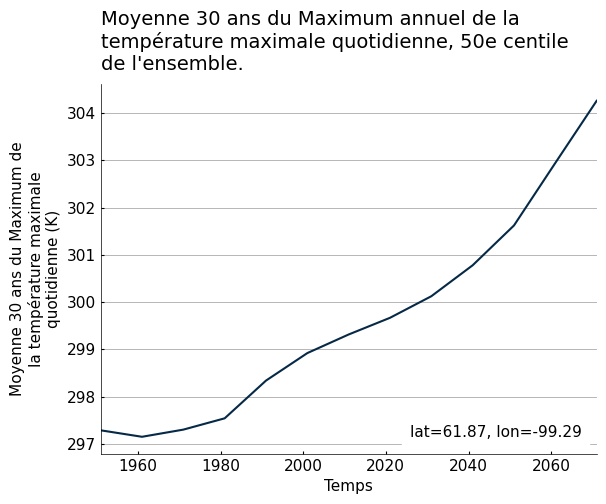

In [15]:
# Populate the example data with french attributes
ds_time.tx_max_p50.attrs.update(
    description_fr="Moyenne 30 ans du Maximum annuel de la température maximale quotidienne, 50e centile de l'ensemble.",
    long_name_fr="Moyenne 30 ans du Maximum de la température maximale quotidienne",
)
with set_options(metadata_locales=["fr"]):
    fg.timeseries(ds_time.tx_max_p50)

## Keyword - colour association

Following the IPCC visual style guidelines and the practices of many other climate organizations, some scenarios (RCPs, SSPs), models and projects (CMIPs) are associated with specific colors. These colours can be implemented in timeseries() through the keys of the `data` argument. If a formulation of such scenarios or model names is found in a key, the corresponding line will be given the appropriate colour. For scenarios, alternative formats such as _ssp585_ or _rcp45_ are also accepted instead of the more formal _SSP5-8.5_ on _RCP4.5_. Model names do not currently have this flexibility. If multiple matching substrings exist, the following order of priority will dictate which colour is used:

1. SSP scenarios
2. RCP scenarios
3. Model names
4. CMIP5 or CMIP6

Here is the list of the accepted substrings and colors.

In [ ]:
color_dict = fg.utils.categorical_colors()

keys = np.array(list(color_dict.keys()))
keys = np.array_split(keys, 3)


fig, ax = plt.subplots(figsize=(8, 10))
ax.set_ylim(-25, 3)
ax.set_xlim(0, 12)
ax.set_axis_off()
for colorlist, x in zip(keys, [1, 5.5, 10]):
    for y in np.arange(len(colorlist)):
        ax.text(
            x,
            -y,
            colorlist[y],
            va="bottom",
            ha="left",
            backgroundcolor="white",
            weight="normal",
            color="k",
        )
        ax.add_patch(
            Rectangle(
                xy=(x - 1, -y),
                width=0.5,
                height=0.5,
                facecolor=tuple([i / 255 for i in color_dict[colorlist[y]]]),
                edgecolor="0.8",
            )
        )

In [ ]:
data = {
    "tasmax_ssp370": ds_time,
    "tasmax_ssp245": ds_time.copy() - 10,
    "tasmax_ssp585": ds_time.copy() + 10,
}

fg.timeseries(data=data, legend="edge", show_lat_lon=False)

In [ ]:
# plt.savefig("images/ensemble_timeseries.png", bbox_inches='tight')